In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./Datasets/train.csv')

In [3]:
import random

test_index_1 = random.sample(list(train[train.Class==1].index), int(15*train[train.Class==1].shape[0]/100))
test_index_0 = random.sample(list(train[train.Class==0].index), int(15*train[train.Class==0].shape[0]/100))

test = train.iloc[test_index_1+test_index_0]
train.drop(test_index_1+test_index_0, inplace=True)

In [4]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0
5,2.00,-0.43,0.96,1.14,-0.17,0.42,-0.03,0.48,0.26,-0.57,...,-0.21,-0.56,-0.03,-0.37,-0.23,0.11,0.25,0.08,3.67,0
6,4.00,1.23,0.14,0.05,1.20,0.19,0.27,-0.01,0.08,0.46,...,-0.17,-0.27,-0.15,-0.78,0.75,-0.26,0.03,0.01,4.99,0


In [5]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,...,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00
mean,94779.60,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,...,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,88.16,0.00
std,47493.86,1.97,1.66,1.52,1.42,1.38,1.33,1.24,1.20,1.10,...,0.74,0.73,0.63,0.61,0.52,0.48,0.40,0.34,250.95,0.04
min,0.00,-56.41,-72.72,-48.33,-5.60,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-9.90,-15.43,0.00,0.00
25%,54181.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.52,0.00
50%,84674.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.00,-0.01,0.04,0.01,-0.05,0.00,0.01,21.95,0.00
75%,139264.00,1.32,0.81,1.03,0.75,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,76.83,0.00
max,172792.00,2.45,22.06,4.23,16.88,34.80,73.30,120.59,20.01,10.39,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


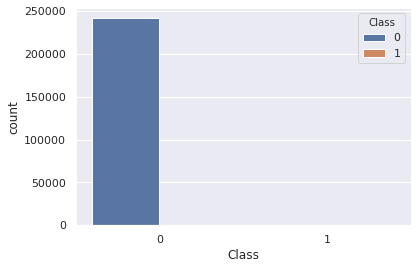

In [6]:
sns.countplot(x='Class', data=train, hue="Class")
plt.show()

In [7]:
print(f"Fraud instaces: {train[train['Class']==1].shape[0]}")
print(f"Non Fraud instaces: {train[train['Class']==0].shape[0]}")
print(f"Fraud percentage: {train[train['Class']==1].shape[0]/train.shape[0]}")
print(f"Non Fraud percentage: {train[train['Class']==0].shape[0]/train.shape[0]}")

Fraud instaces: 419
Non Fraud instaces: 241668
Fraud percentage: 0.001730782735132411
Non Fraud percentage: 0.9982692172648676


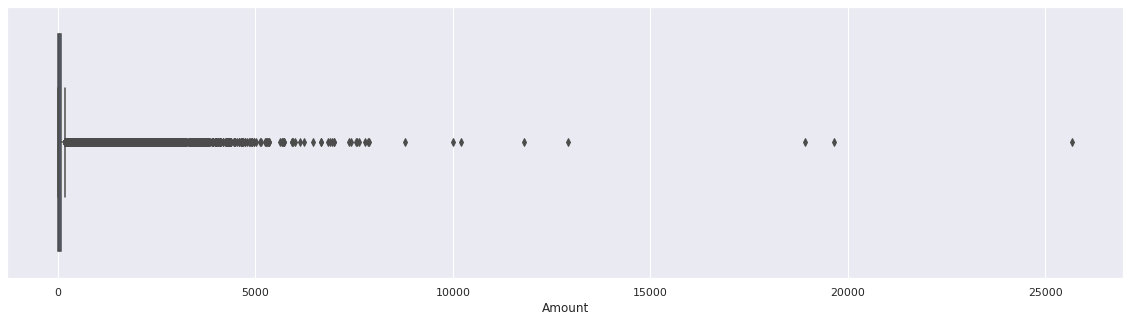

In [8]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=train.Amount)

In [9]:
train = train[train['Amount']  <= 10000]

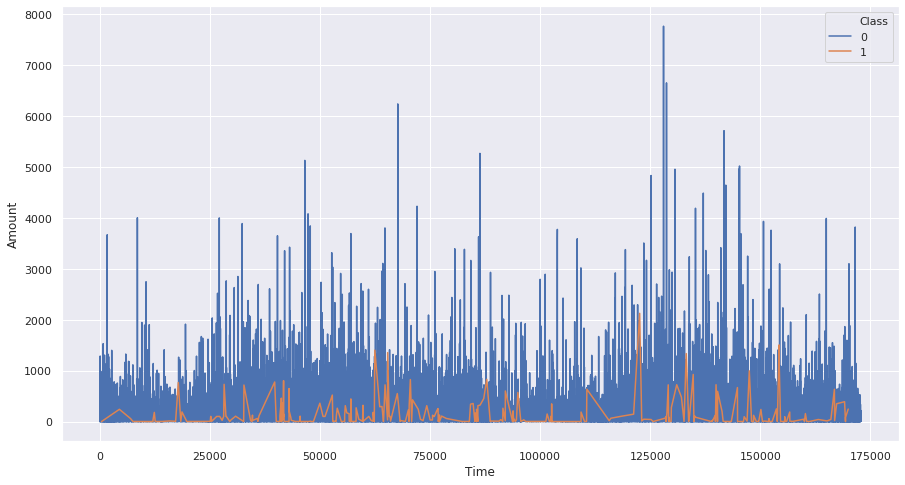

In [10]:
plt.figure(figsize=(15, 8))
sns.lineplot(x="Time", y="Amount", hue="Class", data=train, ci=None)
plt.show()

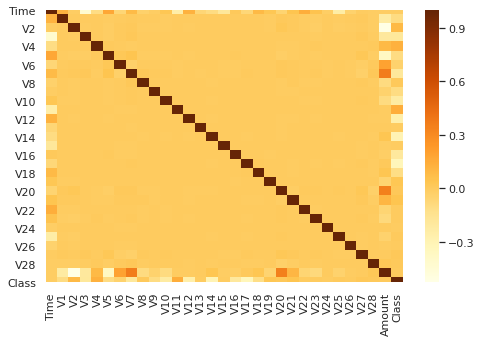

In [11]:
plt.figure(figsize=(8, 5))
sns.heatmap(data = train.corr(), cmap = "YlOrBr")

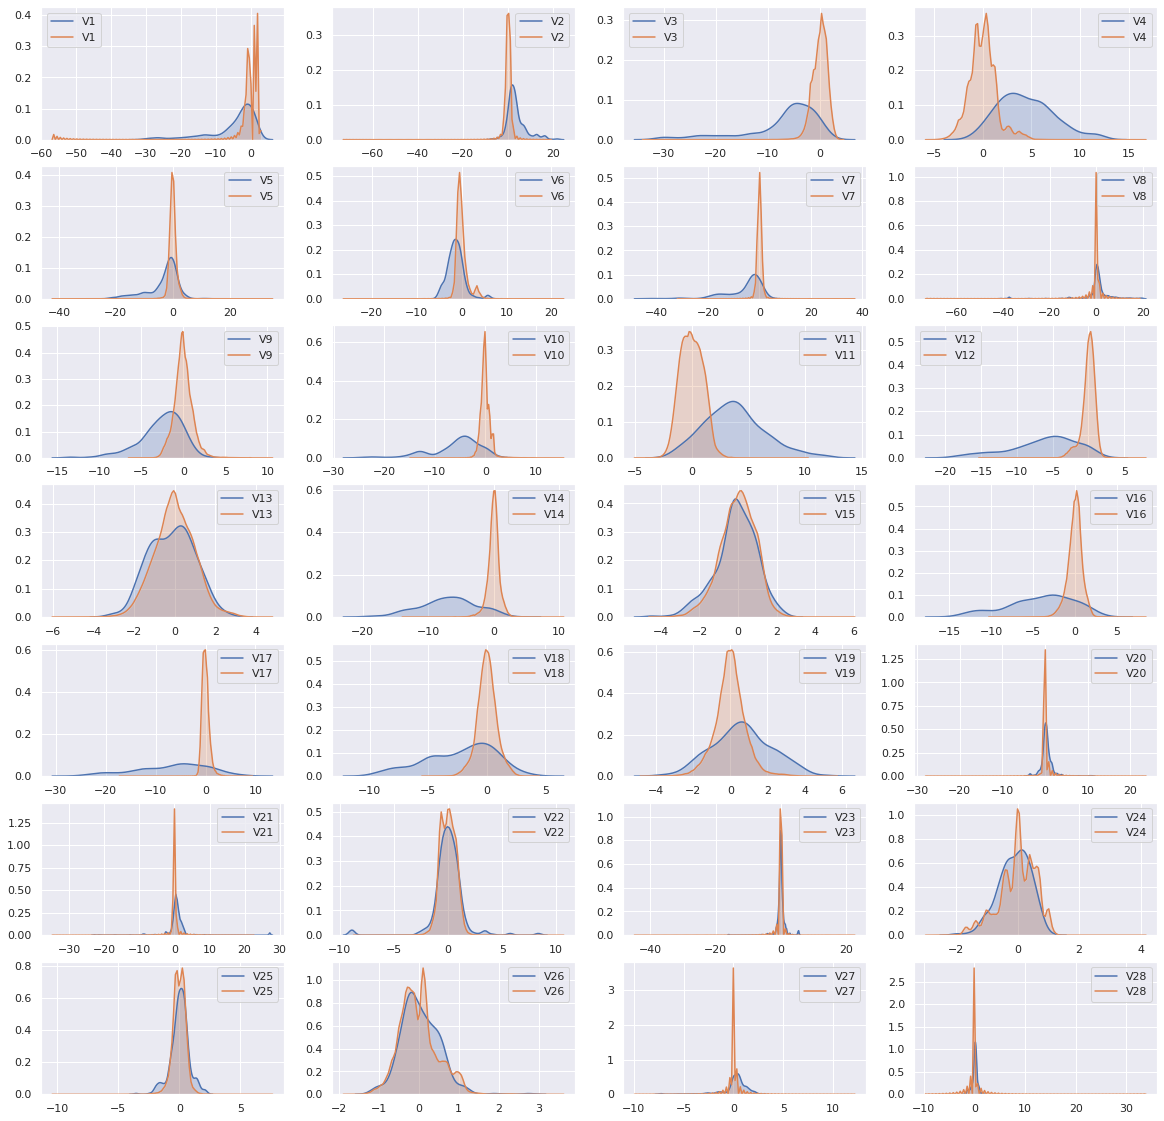

In [12]:
fig, ax = plt.subplots(7, 4, figsize=(20, 20))
for i in range(0, 28):
    sns.kdeplot(train[train['Class']==1][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
    sns.kdeplot(train[train['Class']==0][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
fig.show()

In [13]:
train.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)
test.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train.drop('Class', axis=1))

In [14]:
reduced_data = train[train.Class==0].sample(1000)
reduced_data = pd.concat([reduced_data, train[train.Class==1]], ignore_index=True)
reduced_data = reduced_data.sample(frac=1).reset_index(drop=True)

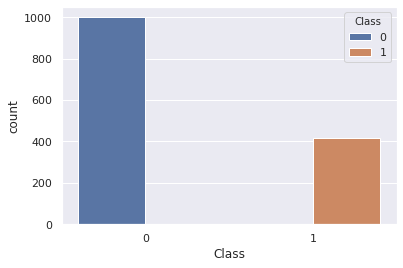

In [65]:
sns.countplot(x='Class', data=reduced_data, hue="Class")

In [15]:
reduced_data_std = scaler.transform(reduced_data.drop('Class', axis=1))
reduced_data_std = pd.DataFrame(reduced_data_std)
reduced_data_std['Class'] = reduced_data.Class
reduced_data_std.columns = reduced_data.columns

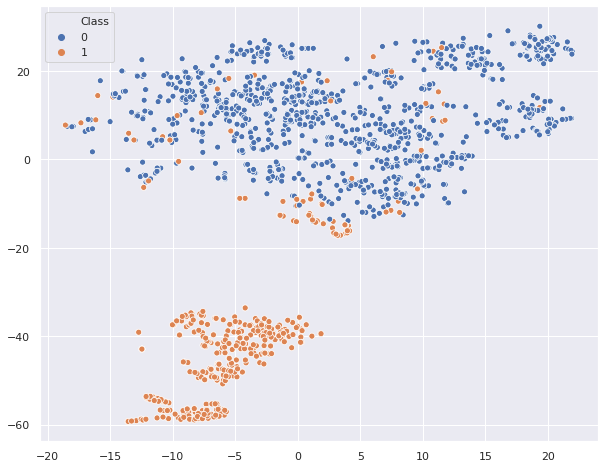

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=75).fit_transform(reduced_data_std)
plt.figure(figsize=(10,8))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=reduced_data_std.Class)

In [19]:
test_y = test.Class
test = test.drop('Class', axis=1)
test = scaler.transform(test)

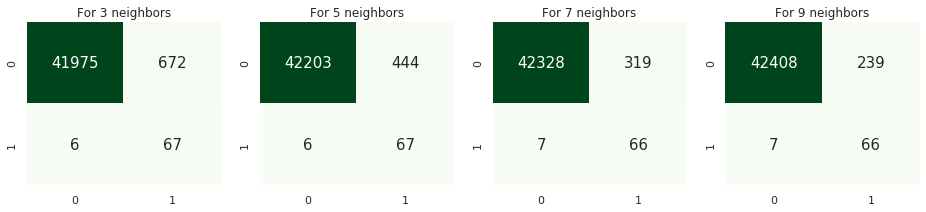

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 4, figsize=(16, 3))
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[i], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[i].get_ylim()
    ax[i].set_ylim(bottom + 0.5, top - 0.5)
    ax[i].title.set_text(f'For {n} neighbors')
    i+=1

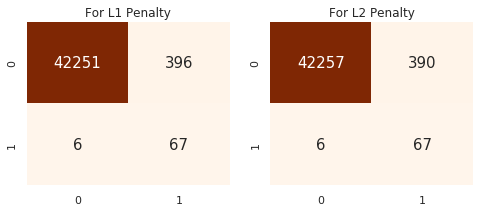

In [55]:
from sklearn.linear_model import LogisticRegression

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For L2 Penalty')

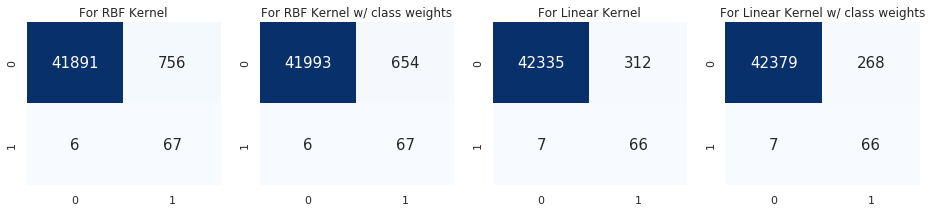

In [64]:
from sklearn.svm import SVC

fig, ax = plt.subplots(1, 4, figsize=(16, 3))

svm = SVC(kernel='rbf')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[2], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[2].get_ylim()
ax[2].set_ylim(bottom + 0.5, top - 0.5)
ax[2].title.set_text(f'For Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[3], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[3].get_ylim()
ax[3].set_ylim(bottom + 0.5, top - 0.5)
ax[3].title.set_text(f'For Linear Kernel w/ class weights')